In [4]:
%matplotlib inline

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
import random

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [5]:
env = BlackjackEnv()

In [6]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation, k=1):
        #epsilon = 1/np.sqrt(k)
        #epislon = 1/k
        epsilon = 1/(k**(7/8))
        probs = np.zeros(nA)
        score, dealer_score, usable_ace = observation
        best_a = np.argmax(Q[observation])
        random_a = random.randint(0, nA - 1)
        return np.random.choice([best_a, random_a], p=[1 - epsilon + (epsilon / nA), epsilon / nA])
    return policy_fn

In [7]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    V = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        episode = []
        observation_state = env.reset() # state
        for t in range(100):
            action = policy(observation_state, k=i_episode)
            next_state, reward, done, _ = env.step(action)
            episode.append((observation_state, action, reward))
            if done:
                break
            observation_state = next_state
            
        ###############################################################################################
        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]
            
            Q[state][action] = Q[state][action] + (1/returns_count[state])*(G-Q[state][action])
            
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return Q, policy, V

# Policy iteration and evaluation using epsilon=1 / (k^(7/8))

--> epsilon is reduced to 5 decimal points at max time steps

Episode 10000/10000.

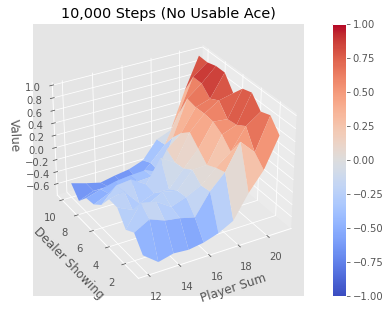

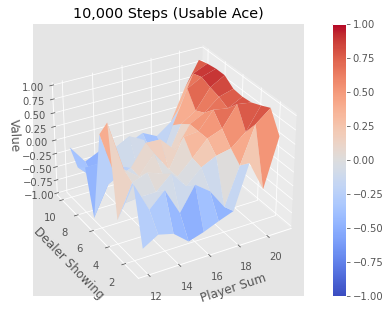

Episode 50000/50000.

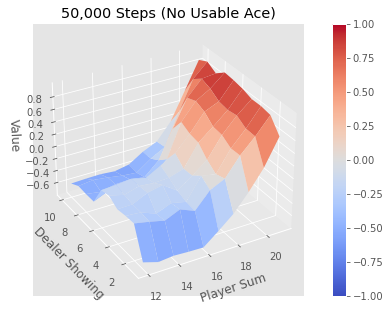

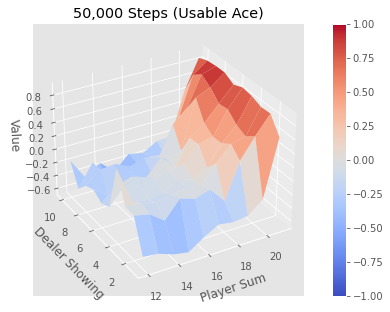

Episode 100000/100000.

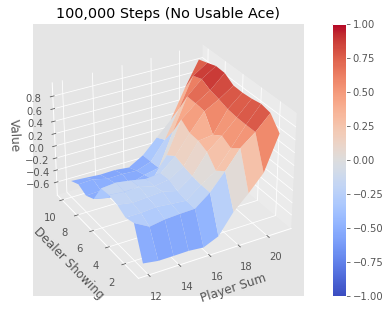

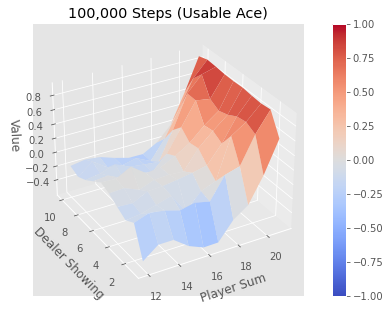

Episode 300000/300000.

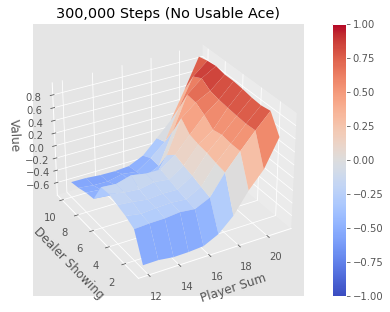

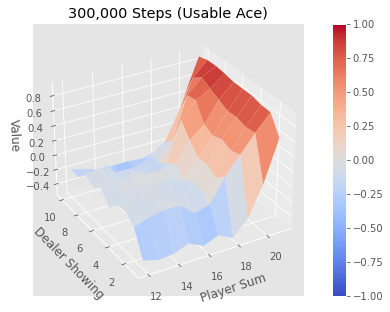

Episode 400000/400000.

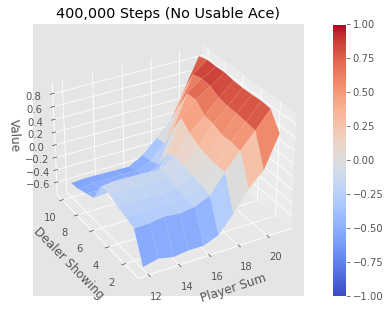

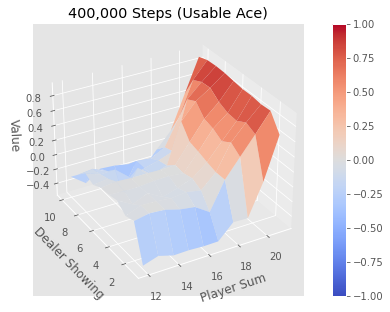

Episode 500000/500000.

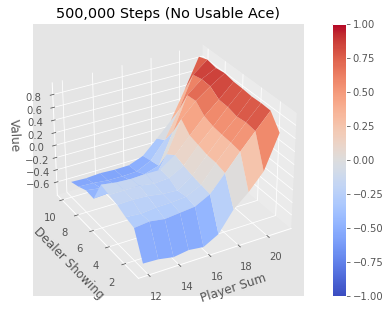

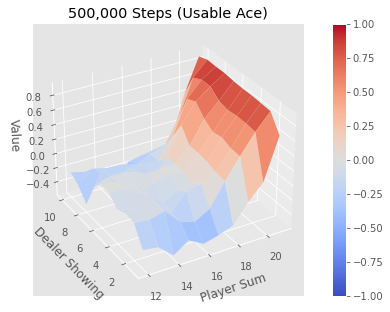


 127.84375 s


In [52]:
start = time.process_time()

returns = {}
time_steps = [10000, 50000, 100000, 300000, 400000, 500000]
for ts in time_steps:
    Q, policy, V = mc_control_epsilon_greedy(env, ts, epsilon=1)
    
    returns_ts = []
    for _ in range(10):
        observation_state = env.reset()
        for t in range(100):
            action = policy[observation_state]
            next_state, reward, done, _ = env.step(action)
            if done:
                returns_ts.append(reward)
                break
            observation_state = next_state
    returns[ts] = returns_ts
        
    plotting.plot_value_function(V, title=f'{ts:,} Steps', figsize=(10,5))

end = time.process_time()
print("\n",end - start,"s")

Standard deviation at 10,000: 0.9165151389911679
Standard deviation at 50,000: 0.8717797887081347
Standard deviation at 100,000: 0.9433981132056605
Standard deviation at 300,000: 0.9165151389911681
Standard deviation at 400,000: 0.9165151389911681
Standard deviation at 500,000: 0.9


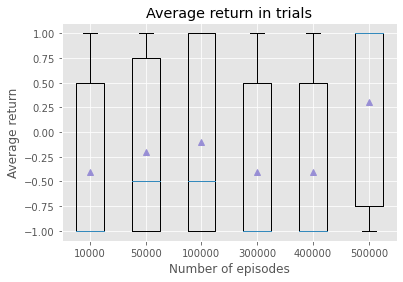

In [53]:
fig, ax = plt.subplots()
bp = ax.boxplot(returns.values(), showmeans=True, labels=returns.keys())
ax.set_title('Average return in trials')
ax.set_xlabel('Number of episodes')
ax.set_ylabel('Average return')
for ts in time_steps:
    print(f'Standard deviation at {ts:,}: {np.std(returns[ts])}')